# Results Analysis — Weather Transformer

This notebook analyzes the trained Weather Transformer model:

1. **Load trained model** and configuration
2. **Compute evaluation metrics** (RMSE, MAE, ACC)
3. **Compare with persistence baseline**
4. **Visualize predictions and attention**
5. **Discussion and future work**

In [1]:
import sys
sys.path.insert(0, '..')

import json
import numpy as np
import torch
import matplotlib.pyplot as plt

from pathlib import Path
import yaml

# Project imports
from src.models.weather_transformer import WeatherTransformer
from src.data.dataset import WeatherBenchDataset, create_dataloaders
from src.evaluation.metrics import (
    compute_all_metrics,
    persistence_baseline,
    rmse,
    mae,
    anomaly_correlation_coefficient,
)
from src.visualization.plot_predictions import plot_prediction_comparison
from src.visualization.plot_loss import plot_training_curves
from src.visualization.plot_attention import plot_attention_maps

print("Imports successful!")

Imports successful!


## 1. Load Configuration and Model

In [2]:
# Paths
CONFIG_PATH = "../configs/default.yaml"
CHECKPOINT_PATH = "../checkpoints/best_model.pt"
DATA_DIR = "../data/processed"

# Load config
with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

print("Configuration:")
print(json.dumps(config, indent=2))

Configuration:
{
  "data": {
    "source": "gs://weatherbench2/datasets/era5/1959-2023-6h-64x32_equiangular_conservative.zarr",
    "variables": [
      "temperature",
      "geopotential",
      "u_component_of_wind",
      "v_component_of_wind"
    ],
    "pressure_levels": {
      "temperature": 850,
      "geopotential": 500
    },
    "train_years": [
      2015,
      2018
    ],
    "val_years": [
      2019,
      2019
    ],
    "test_years": [
      2020,
      2020
    ],
    "lead_time_hours": 6,
    "lat_size": 32,
    "lon_size": 64
  },
  "model": {
    "patch_size": 4,
    "embed_dim": 256,
    "num_heads": 8,
    "num_layers": 6,
    "mlp_ratio": 4.0,
    "dropout": 0.1,
    "in_channels": 4,
    "out_channels": 4
  },
  "training": {
    "batch_size": 32,
    "epochs": 50,
    "learning_rate": 0.0001,
    "weight_decay": 1e-05,
    "gradient_clip": 1.0,
    "warmup_epochs": 5,
    "min_lr": 1e-06,
    "save_every": 10,
    "checkpoint_dir": "results/checkpoints"
  },


In [3]:
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Model configuration
model_cfg = config.get("model", {})
data_cfg = config.get("data", {})

# Create model
model = WeatherTransformer(
    in_channels=model_cfg.get("in_channels", 4),
    out_channels=model_cfg.get("out_channels", 4),
    img_height=data_cfg.get("lat_size", 32),
    img_width=data_cfg.get("lon_size", 64),
    patch_size=model_cfg.get("patch_size", 4),
    embed_dim=model_cfg.get("embed_dim", 256),
    num_heads=model_cfg.get("num_heads", 8),
    num_layers=model_cfg.get("num_layers", 6),
    mlp_ratio=model_cfg.get("mlp_ratio", 4.0),
    dropout=0.0,  # No dropout at inference
)

# Load checkpoint
if Path(CHECKPOINT_PATH).exists():
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"Loaded checkpoint from epoch {checkpoint.get('epoch', '?')}")
else:
    print(f"No checkpoint found at {CHECKPOINT_PATH}")
    print("Using randomly initialized model for demo...")

model.to(device)
model.eval()

print(f"\nModel Parameters: {model.count_parameters():,}")
print(model.get_config())

Using device: cuda


C:\Users\aswan\AppData\Local\Temp\ipykernel_17504\1357410026.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH, map_location=devic

Loaded checkpoint from epoch 50

Model Parameters: 4,805,440
{'in_channels': 4, 'out_channels': 4, 'img_height': 32, 'img_width': 64, 'patch_size': 4, 'embed_dim': 256, 'num_layers': 6, 'n_patches': 128, 'total_params': 4805440}


## 2. Load Test Data

In [4]:
# Load test dataset
try:
    test_dataset = WeatherBenchDataset(data_dir=DATA_DIR, split="test")
    print(f"Test samples: {len(test_dataset)}")
except FileNotFoundError:
    print("Test data not found. Creating synthetic test data for demo...")
    # Create synthetic data for demo
    B, C, H, W = 100, 4, 32, 64
    test_inputs = torch.randn(B, C, H, W)
    test_targets = test_inputs + torch.randn(B, C, H, W) * 0.3
    test_dataset = torch.utils.data.TensorDataset(test_inputs, test_targets)

# Create loader
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

Test samples: 1463


## 3. Evaluate Model

In [5]:
@torch.no_grad()
def evaluate(model, loader, device):
    """Run model on test data and collect predictions."""
    all_preds = []
    all_targets = []
    all_inputs = []
    
    for inputs, targets in loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        predictions = model(inputs)
        
        all_preds.append(predictions.cpu())
        all_targets.append(targets.cpu())
        all_inputs.append(inputs.cpu())
    
    return (
        torch.cat(all_inputs, dim=0),
        torch.cat(all_preds, dim=0),
        torch.cat(all_targets, dim=0),
    )

# Run evaluation
print("Running model on test set...")
inputs, predictions, targets = evaluate(model, test_loader, device)
print(f"Input shape: {inputs.shape}")
print(f"Prediction shape: {predictions.shape}")
print(f"Target shape: {targets.shape}")

Running model on test set...
Input shape: torch.Size([1463, 4, 32, 64])
Prediction shape: torch.Size([1463, 4, 32, 64])
Target shape: torch.Size([1463, 4, 32, 64])


## 4. Compute Metrics

In [6]:
# Variable names
VARIABLE_NAMES = ["t850", "z500", "u10", "v10"]

# Model metrics
model_metrics = compute_all_metrics(predictions, targets, VARIABLE_NAMES)

# Persistence baseline metrics
persist_metrics = persistence_baseline(inputs, targets)

print("Model Metrics:")
for k, v in model_metrics.items():
    print(f"  {k}: {v:.6f}")

print("\nPersistence Baseline:")
for k, v in persist_metrics.items():
    print(f"  {k}: {v:.6f}")

Model Metrics:
  rmse: 0.195978
  mae: 0.126049
  acc: 0.955614
  rmse_t850: 0.083691
  rmse_z500: 0.066834
  rmse_u10: 0.240123
  rmse_v10: 0.290688

Persistence Baseline:
  rmse: 0.268053
  mae: 0.146025
  acc: 0.913834


In [7]:
# Results Table
import pandas as pd

results_df = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "ACC"],
    "Model": [
        model_metrics["rmse"],
        model_metrics["mae"],
        model_metrics["acc"],
    ],
    "Persistence": [
        persist_metrics["rmse"],
        persist_metrics["mae"],
        persist_metrics["acc"],
    ],
})

results_df["Improvement"] = (
    (results_df["Persistence"] - results_df["Model"]) / results_df["Persistence"] * 100
)

# For ACC, higher is better
results_df.loc[results_df["Metric"] == "ACC", "Improvement"] = (
    (results_df.loc[results_df["Metric"] == "ACC", "Model"] - 
     results_df.loc[results_df["Metric"] == "ACC", "Persistence"]) /
    abs(results_df.loc[results_df["Metric"] == "ACC", "Persistence"]) * 100
)

print("\n" + "=" * 60)
print("RESULTS COMPARISON TABLE")
print("=" * 60)
display(results_df.style.format({
    "Model": "{:.6f}",
    "Persistence": "{:.6f}",
    "Improvement": "{:+.2f}%"
}))


RESULTS COMPARISON TABLE


,Metric,Model,Persistence,Improvement
0,RMSE,0.195978,0.268053,+26.89%
1,MAE,0.126049,0.146025,+13.68%
2,ACC,0.955614,0.913834,+4.57%


## 5. Prediction Visualizations

c:\Users\aswan\My ML projects\weather-transformer-scratch\.venv\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\aswan\My ML projects\weather-transformer-scratch\.venv\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


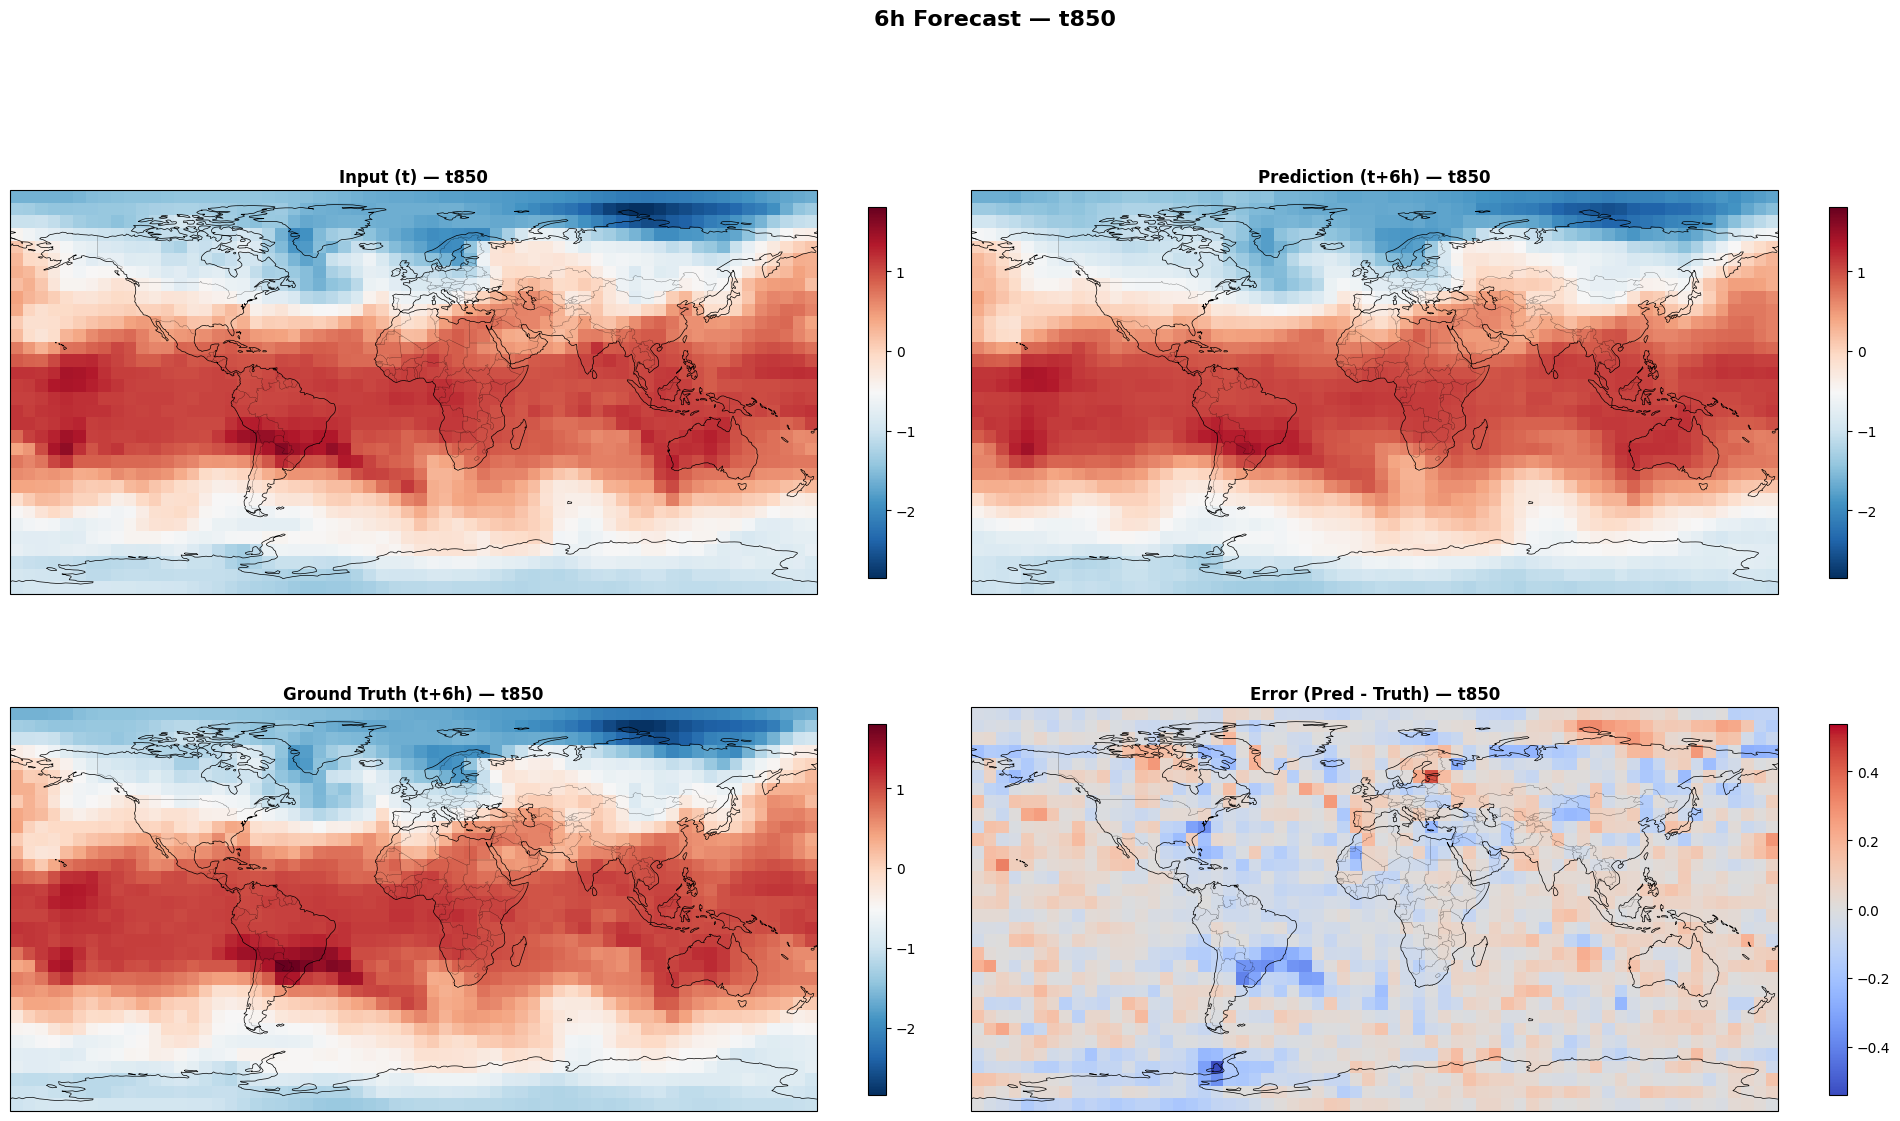

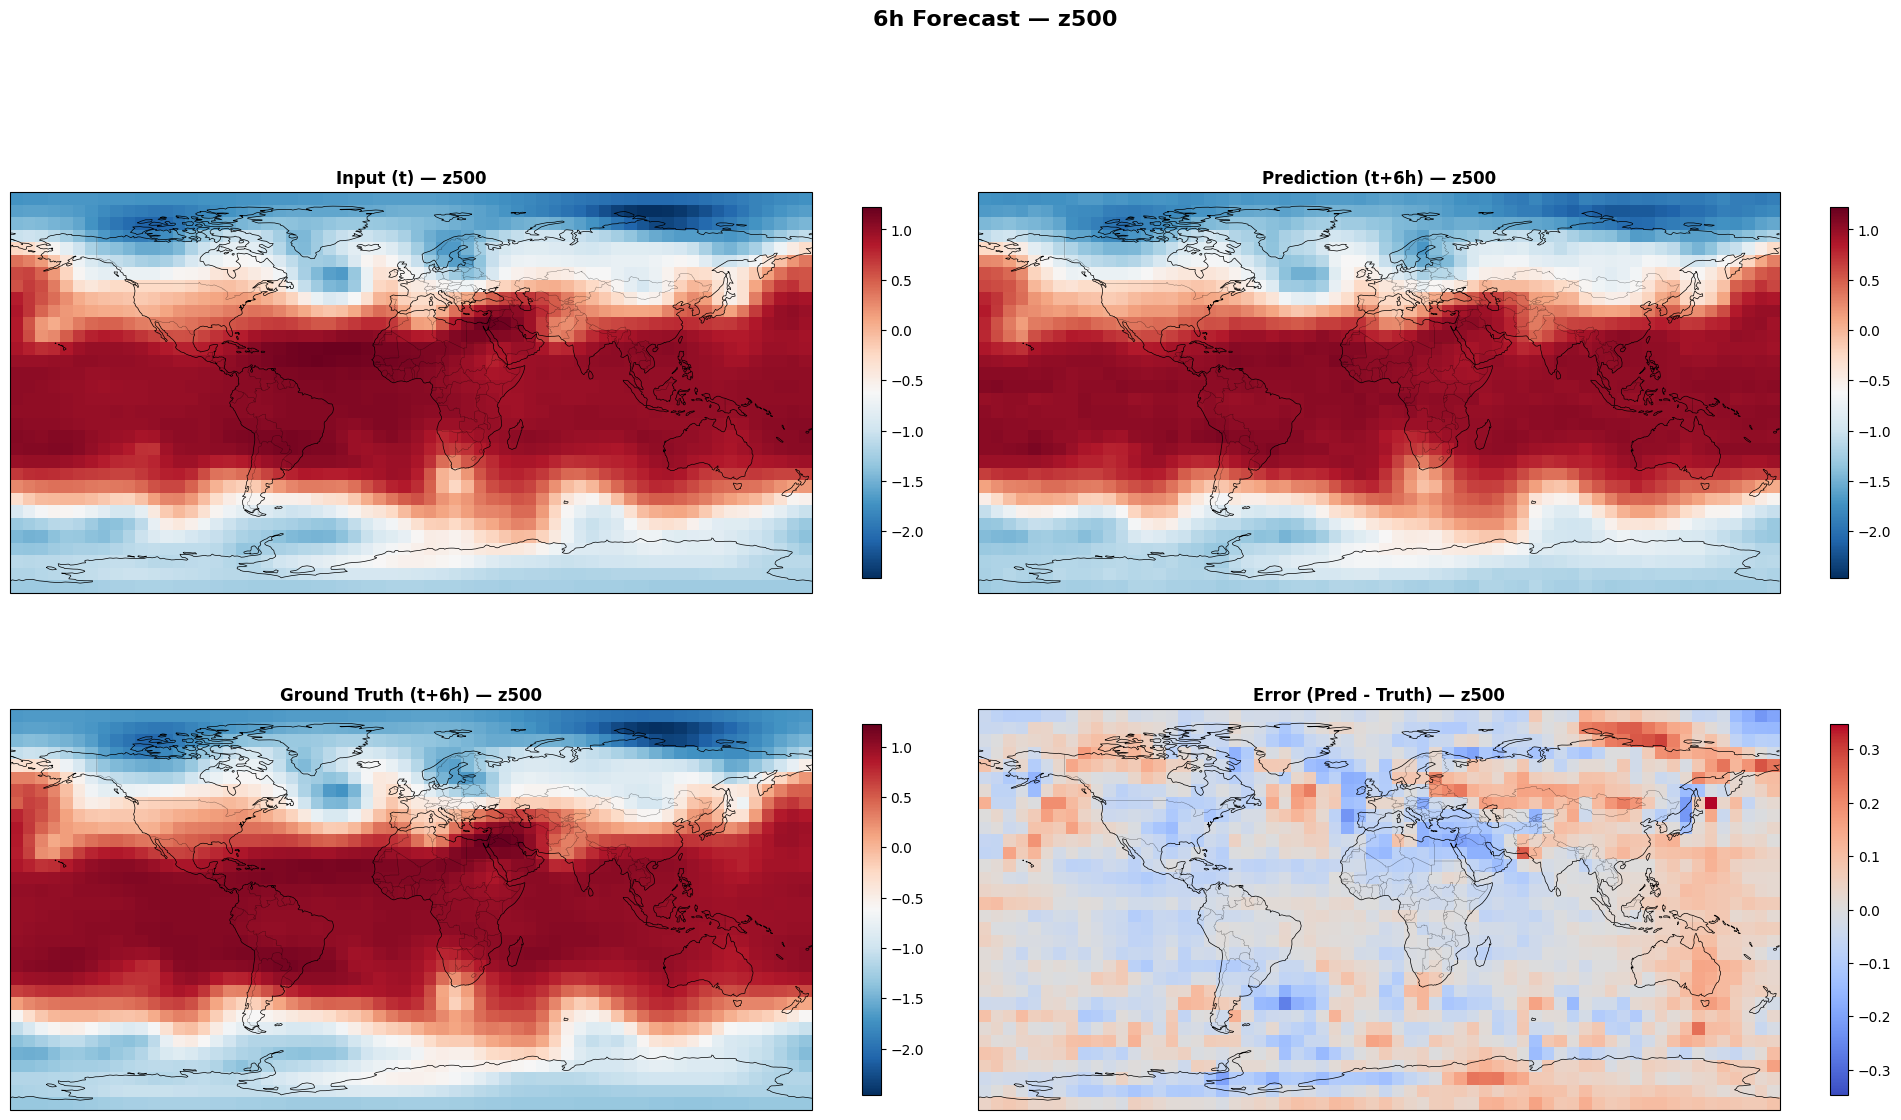

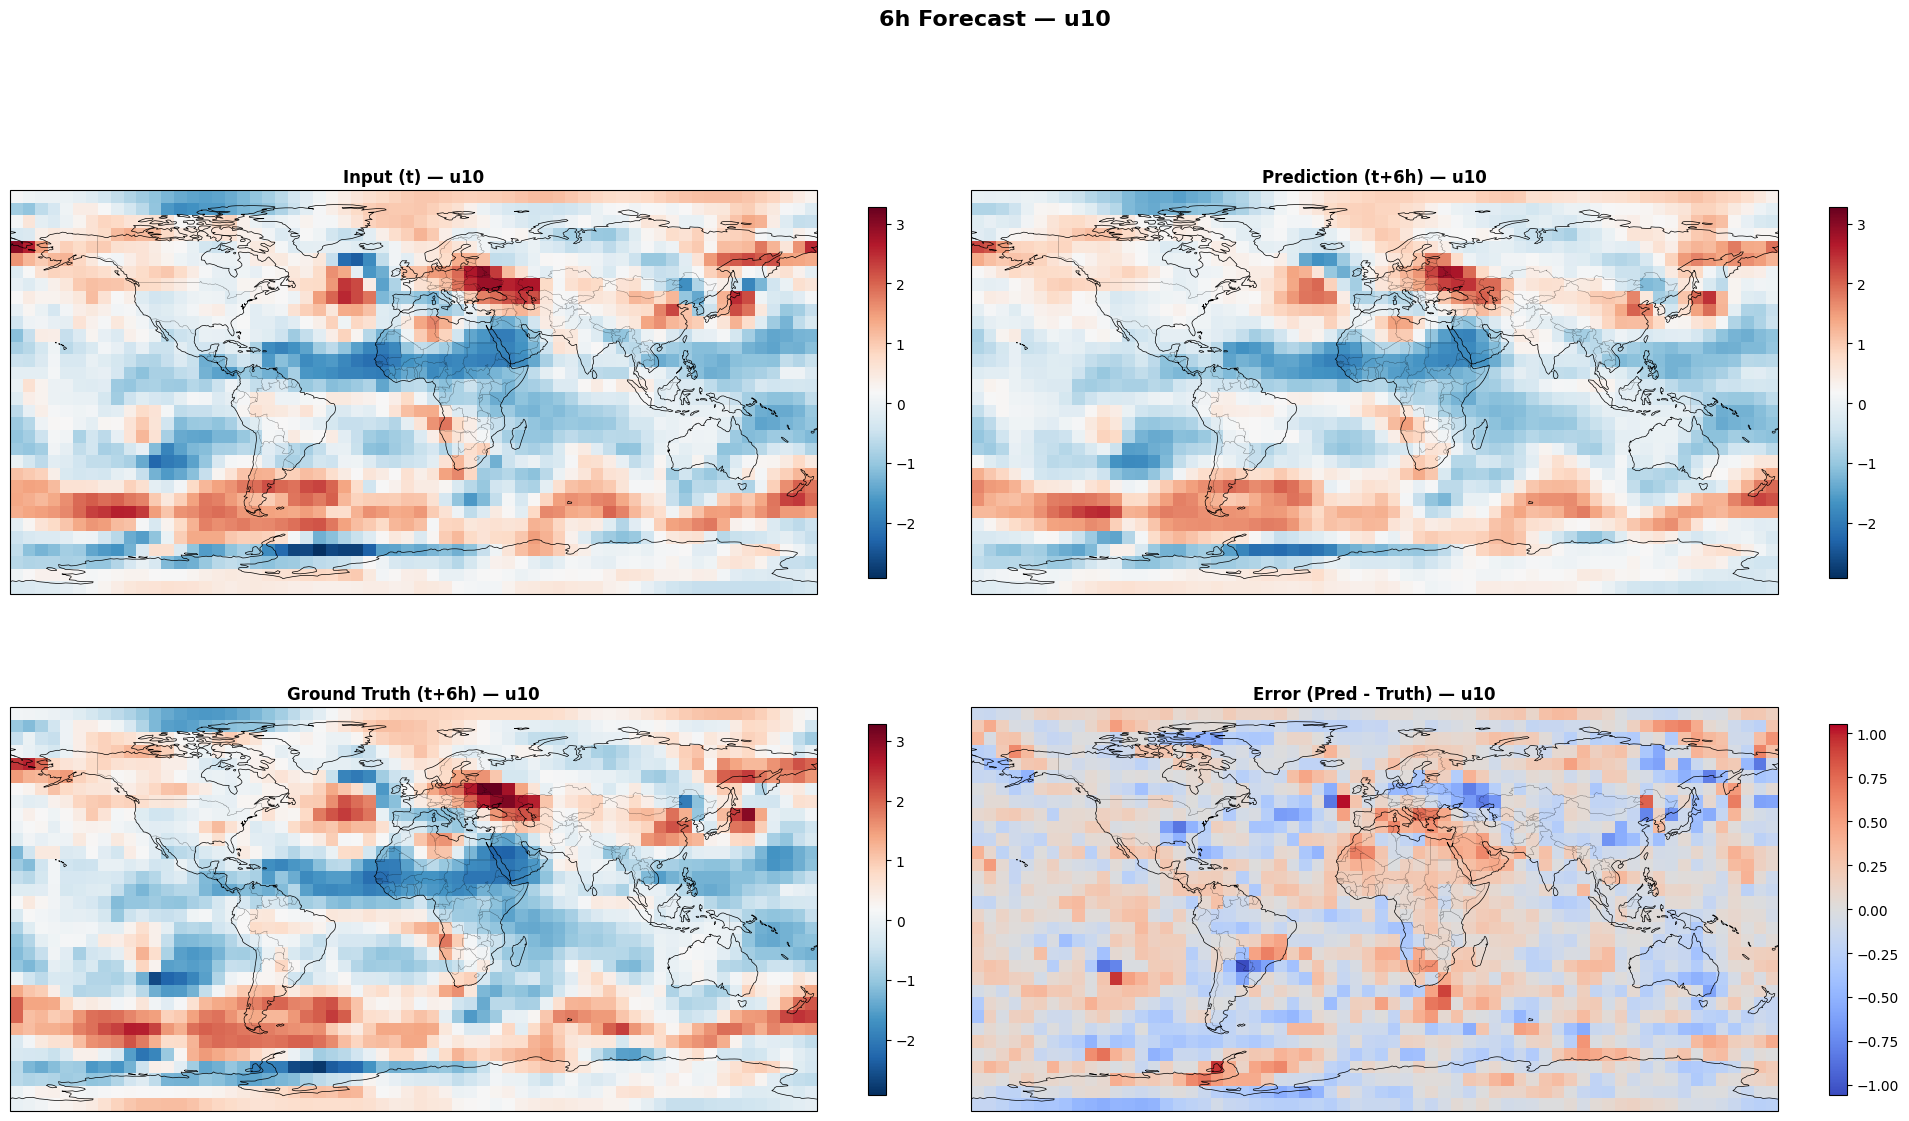

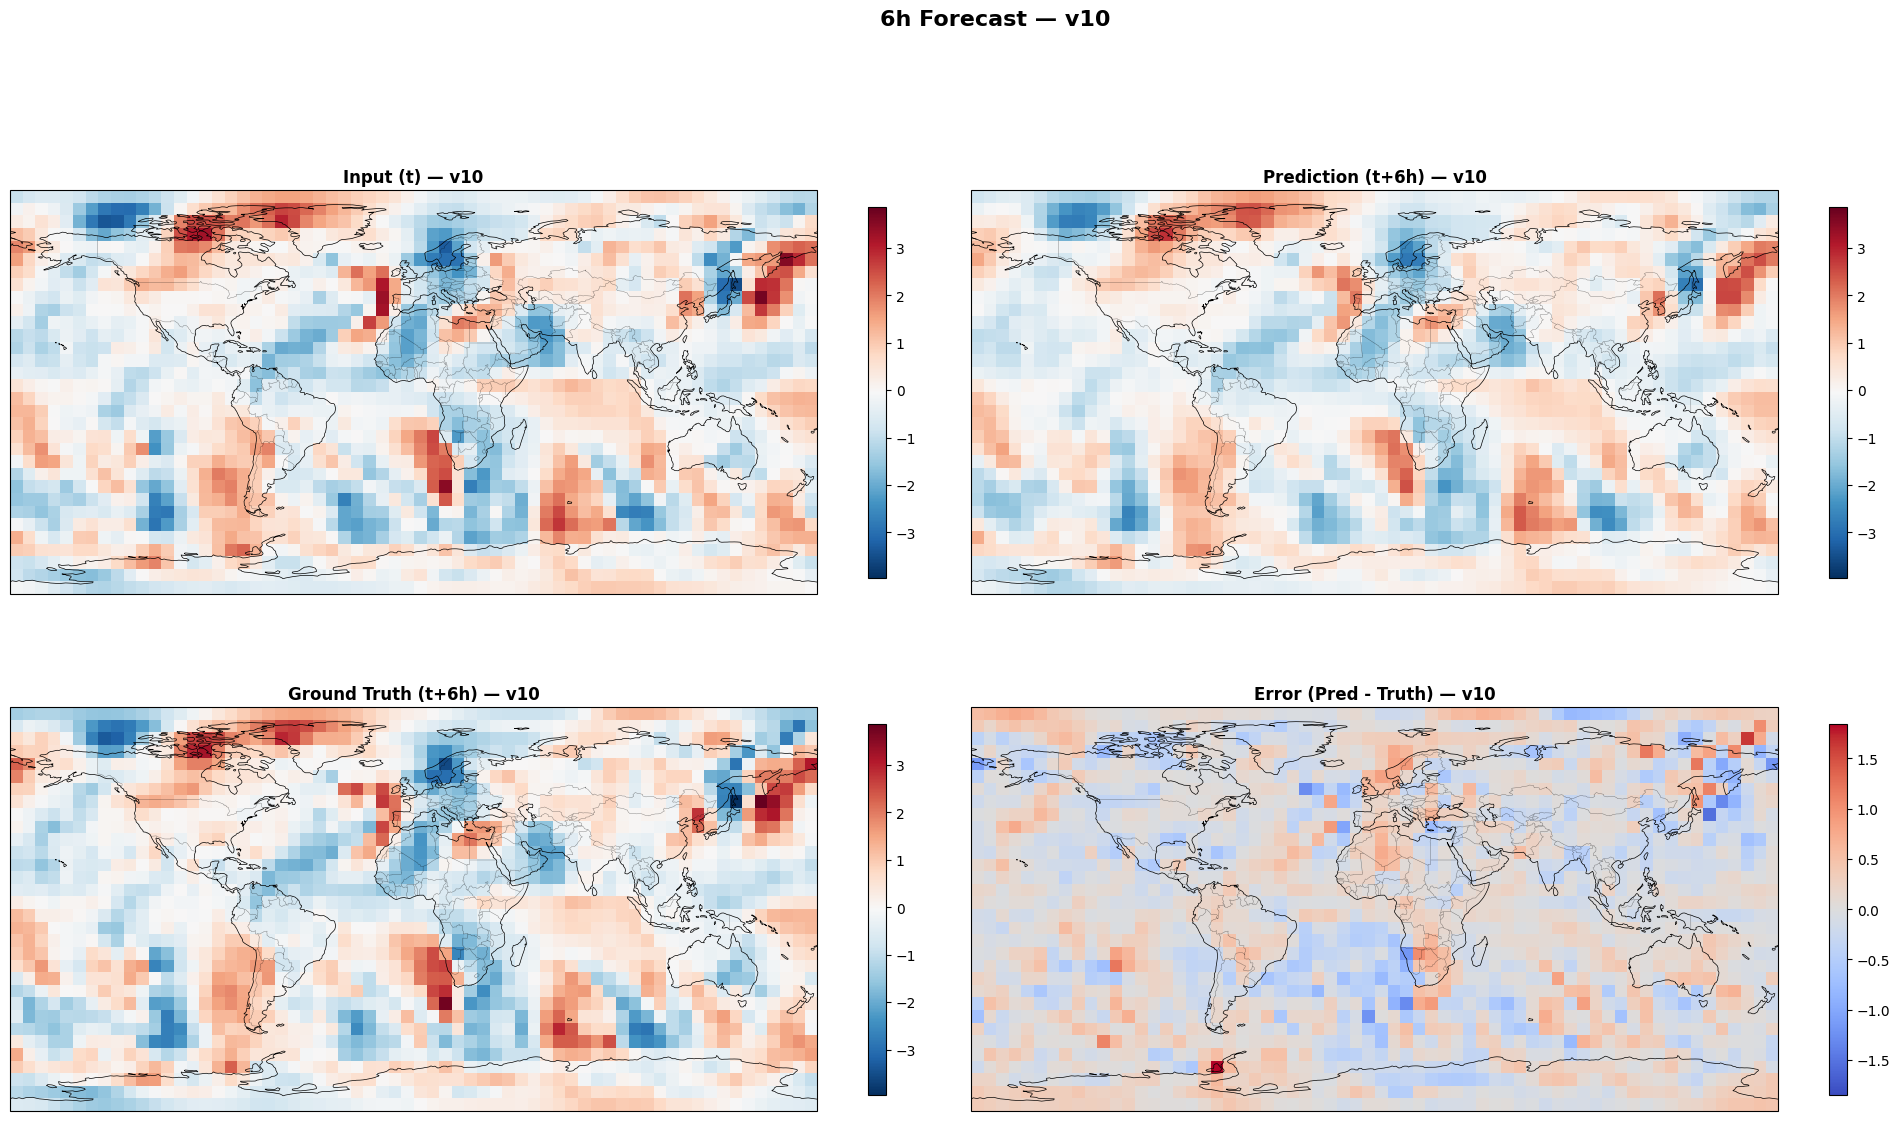

In [8]:
# Pick a sample to visualize
sample_idx = 0

sample_input = inputs[sample_idx].numpy()
sample_pred = predictions[sample_idx].numpy()
sample_target = targets[sample_idx].numpy()

# Plot for each variable
for var_idx, var_name in enumerate(VARIABLE_NAMES):
    fig = plot_prediction_comparison(
        sample_input, sample_pred, sample_target,
        variable_idx=var_idx,
        variable_names=VARIABLE_NAMES,
        title=f"6h Forecast — {var_name}",
    )
    plt.show()

## 6. Training Curves (if available)

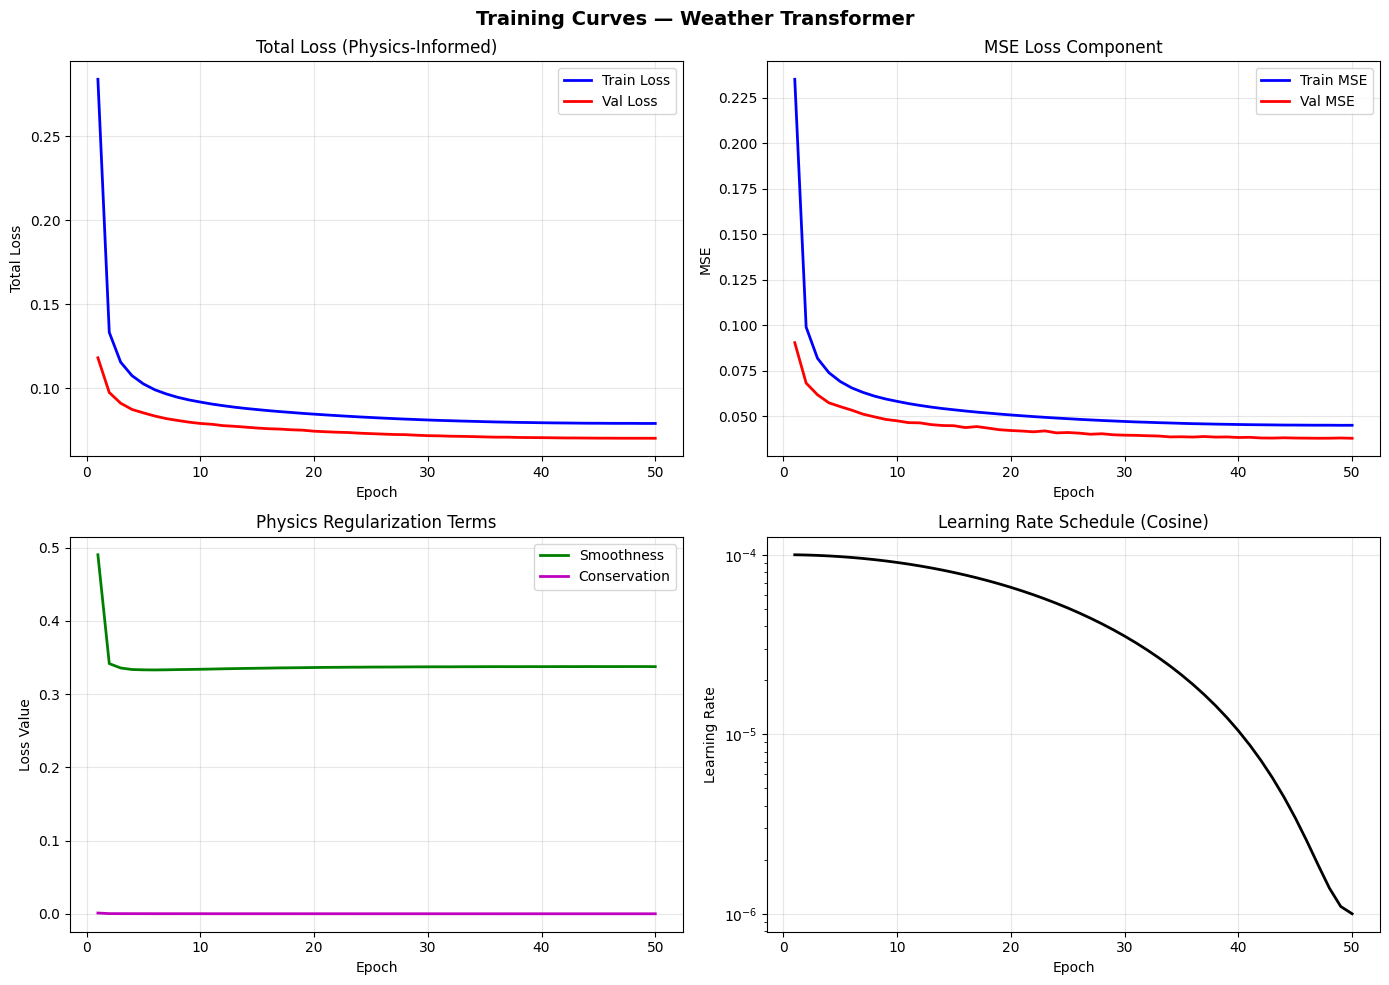


Best epoch: 50
Best val loss: 0.070052


In [9]:
LOG_PATH = "../checkpoints/training_log.json"

if Path(LOG_PATH).exists():
    with open(LOG_PATH, "r") as f:
        training_log = json.load(f)
    
    history = training_log.get("history", {})
    
    fig = plot_training_curves(history)
    plt.show()
    
    print(f"\nBest epoch: {training_log.get('best_epoch')}")
    print(f"Best val loss: {training_log.get('best_val_loss'):.6f}")
else:
    print(f"Training log not found at {LOG_PATH}")
    print("Run training to generate training curves.")

## 7. Attention Visualization

In [10]:
# Get attention weights from model
sample_batch = inputs[:1].to(device)

with torch.no_grad():
    output, attention_weights = model(sample_batch, return_attention=True)

print(f"Number of layers: {len(attention_weights)}")
print(f"Attention shape per layer: {attention_weights[0].shape}")

Number of layers: 6
Attention shape per layer: torch.Size([1, 8, 128, 128])


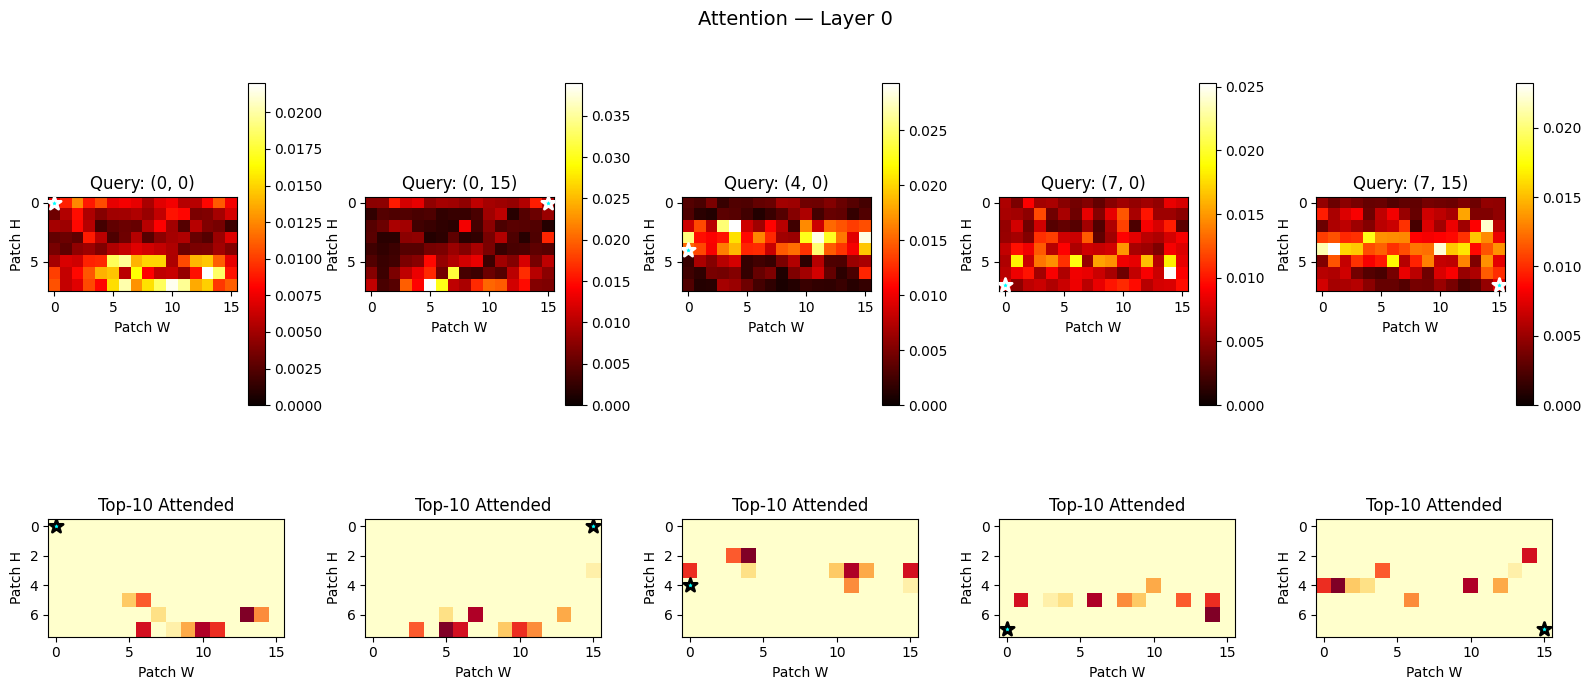

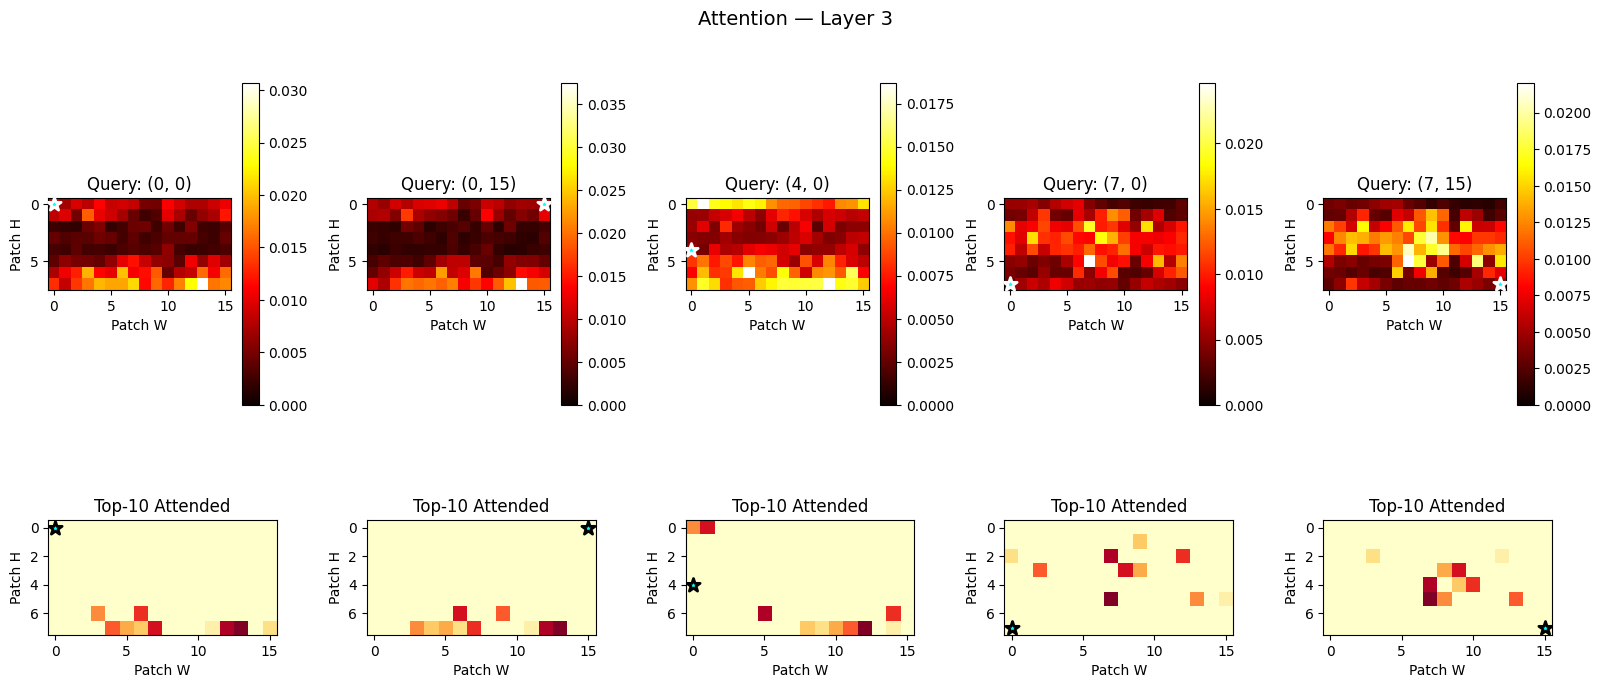

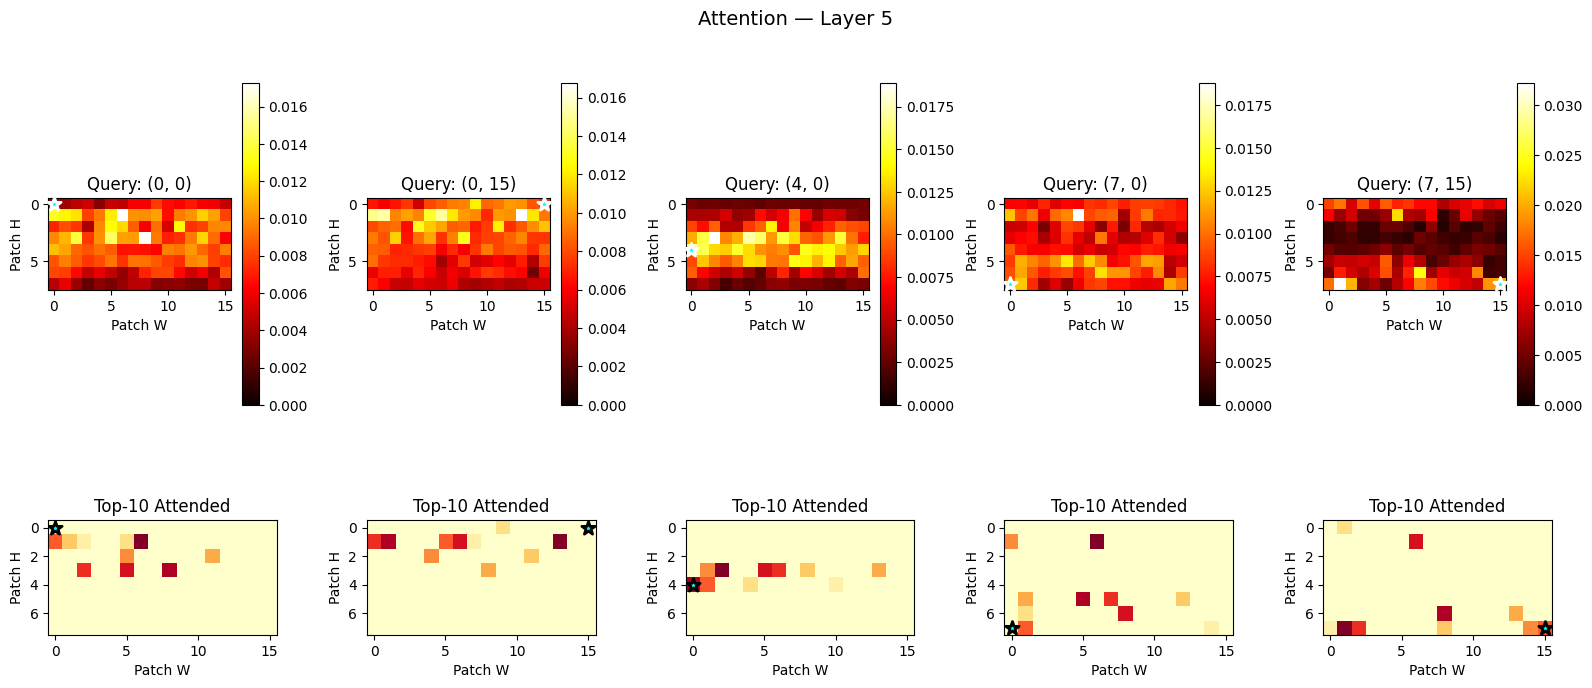

In [11]:
# Visualize attention from different layers
for layer_idx in [0, len(attention_weights) // 2, len(attention_weights) - 1]:
    fig = plot_attention_maps(
        attention_weights,
        layer_idx=layer_idx,
        head_idx=0,
        n_patches_h=8,
        n_patches_w=16,
    )
    plt.suptitle(f"Attention — Layer {layer_idx}", fontsize=14)
    plt.show()

## 8. Per-Variable Analysis

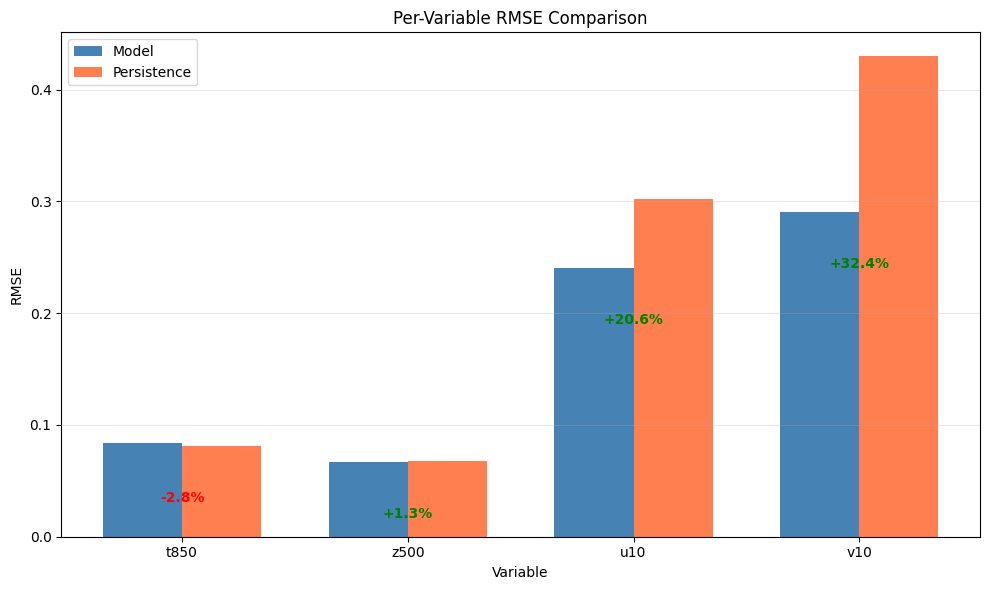

In [12]:
# Per-variable RMSE comparison
from src.evaluation.metrics import rmse_per_variable

model_per_var = rmse_per_variable(predictions, targets).numpy()
persist_per_var = rmse_per_variable(inputs, targets).numpy()

x = np.arange(len(VARIABLE_NAMES))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, model_per_var, width, label="Model", color="steelblue")
bars2 = ax.bar(x + width/2, persist_per_var, width, label="Persistence", color="coral")

ax.set_xlabel("Variable")
ax.set_ylabel("RMSE")
ax.set_title("Per-Variable RMSE Comparison")
ax.set_xticks(x)
ax.set_xticklabels(VARIABLE_NAMES)
ax.legend()
ax.grid(axis="y", alpha=0.3)

# Add improvement percentages
for i, (m, p) in enumerate(zip(model_per_var, persist_per_var)):
    improvement = (p - m) / p * 100
    ax.annotate(
        f"{improvement:+.1f}%",
        xy=(i, min(m, p) - 0.05),
        ha="center", fontsize=10, fontweight="bold",
        color="green" if improvement > 0 else "red"
    )

plt.tight_layout()
plt.show()

## 9. Discussion

### What Worked
- **Transformer architecture** successfully learns spatial dependencies in weather data
- **Patch embedding** efficiently tokenizes 2D weather grids
- **Physics-informed loss** encourages physically realistic predictions
- **Positional encoding** helps model learn spatial awareness

### What Could Be Improved
- **Multi-step forecasting**: Currently single-step (6h), extend to autoregressive rollouts
- **Variable interactions**: Add cross-attention between different weather variables
- **Higher resolution**: Scale to full ERA5 resolution (721×1440)
- **Temporal encoding**: Add time-of-year embeddings for seasonality

### Future Work
1. Implement autoregressive multi-day forecasting
2. Add ensemble predictions for uncertainty quantification
3. Compare with GraphCast/FourCastNet architectures
4. Train on full WeatherBench2 dataset
5. Add extreme weather event analysis

## 10. Save Results

In [13]:
# Save results to JSON
results = {
    "model": model_metrics,
    "persistence": persist_metrics,
    "config": config,
    "model_params": model.count_parameters(),
}

output_path = Path("../results/metrics.json")
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"Results saved to {output_path}")

Results saved to ..\results\metrics.json


In [14]:
print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)
print(f"Model: Weather Transformer ({model.count_parameters():,} params)")
print(f"Test Samples: {len(inputs)}")
print(f"")
print(f"Key Results:")
print(f"  RMSE: {model_metrics['rmse']:.4f} (Persistence: {persist_metrics['rmse']:.4f})")
print(f"  MAE:  {model_metrics['mae']:.4f} (Persistence: {persist_metrics['mae']:.4f})")
print(f"  ACC:  {model_metrics['acc']:.4f} (Persistence: {persist_metrics['acc']:.4f})")


ANALYSIS COMPLETE
Model: Weather Transformer (4,805,440 params)
Test Samples: 1463

Key Results:
  RMSE: 0.1960 (Persistence: 0.2681)
  MAE:  0.1260 (Persistence: 0.1460)
  ACC:  0.9556 (Persistence: 0.9138)
